In [1]:
import re

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import display, Markdown
from pathlib import Path
from collections import defaultdict

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")

In [4]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
EXECUTION_PATTERN = re.compile(r"The simulation took:\n - initialisation: ([^\n]+)\n - execution: ([^\n]+)\n - cleanup: ([^\n]+)\n")

In [5]:
TIME_PATTERN = re.compile(r"(\d+(?:\.\d+)?)([^\d]+)")
TIME_UNITS = {
    "ns": 0.000000001,
    "µs": 0.000001,
    "ms": 0.001,
    "s": 1.0,
}

def parse_time(time_str):
    match = TIME_PATTERN.match(time_str)
    
    if match is None:
        return None
    
    return float(match.group(1)) * TIME_UNITS[match.group(2)]

In [6]:
PARTITIONS_FILE_PATTERN = re.compile(r"pbs\.(\d+)\.o\d+\.\d+")
ISOLATED_PARTITIONS_FILE_PATTERN = re.compile(r"pbs\.(\d+)\.isolated\.o\d+\.\d+")
ISOLATED_REPLAY_FILE_PATTERN = re.compile(r"pbs\.(\d+)(?:\[\])?\.o\d+")

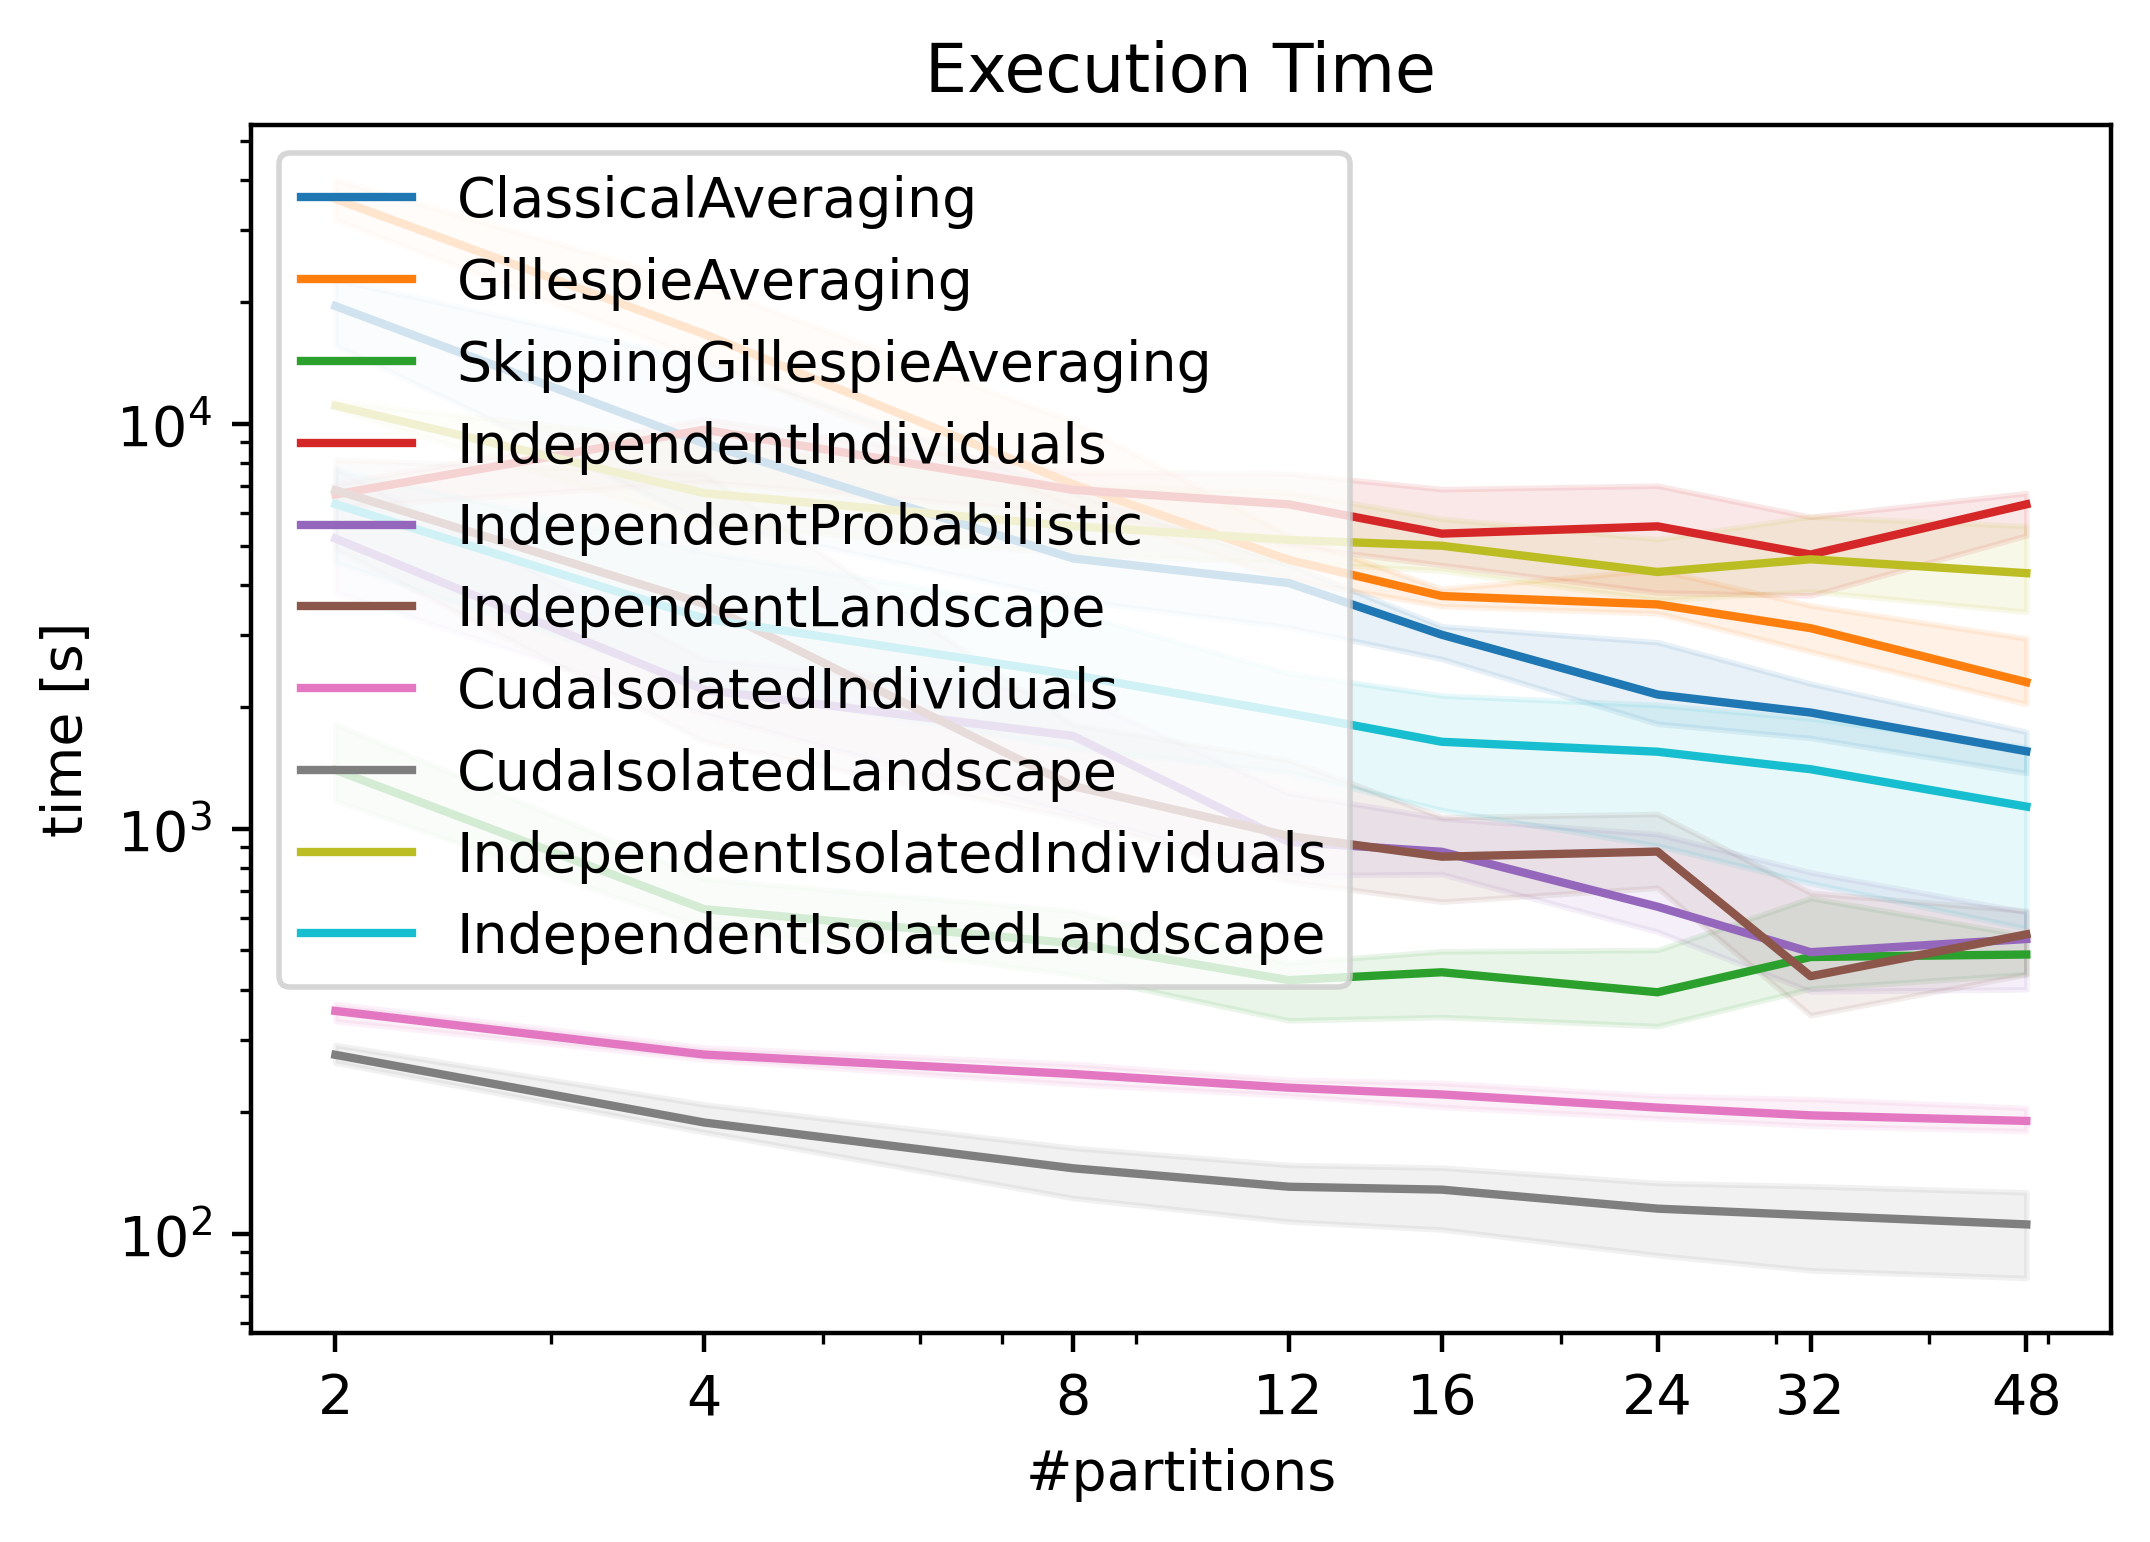

In [7]:
plt.title("Execution Time")
plt.xlabel("#partitions")
plt.ylabel("time [s]")
plt.xscale("log")
plt.yscale("log")

for algorithm in [
    "ClassicalAveraging", "GillespieAveraging", "SkippingGillespieAveraging",
    "ClassicalLockstep", "GillespieLockstep", "SkippingGillespieLockstep",
    "ClassicalOptimisticLockstep", "GillespieOptimisticLockstep", "SkippingGillespieOptimisticLockstep",
    "IndependentIndividuals", "IndependentProbabilistic", "IndependentLandscape"
]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = BIODIVERSITY_PATTERN.search(stdout)
        if match is None:
            continue
        biodiversity = int(match.group(1))

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))

        results[partitions].append((biodiversity, initialisation, execution, cleanup))
        
    if len(results) == 0:
        continue

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, biodiversities, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    plt.plot(partitionss, np.array(executions)[:,0], label=algorithm)
    plt.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=plt.gca().lines[-1].get_color(), alpha=0.1
    )
    
for algorithm in ["CudaIsolatedIndividuals", "CudaIsolatedLandscape", "IndependentIsolatedIndividuals", "IndependentIsolatedLandscape"]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = ISOLATED_PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            print(path)
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))
        
        results[partitions].append((initialisation, execution, cleanup))

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    plt.plot(partitionss, np.array(executions)[:,0], label=algorithm)
    plt.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=plt.gca().lines[-1].get_color(), alpha=0.1
    )
    
ylim = plt.ylim()

plt.xticks(partitionss, labels=[str(p) for p in partitionss])

plt.legend()
plt.show()

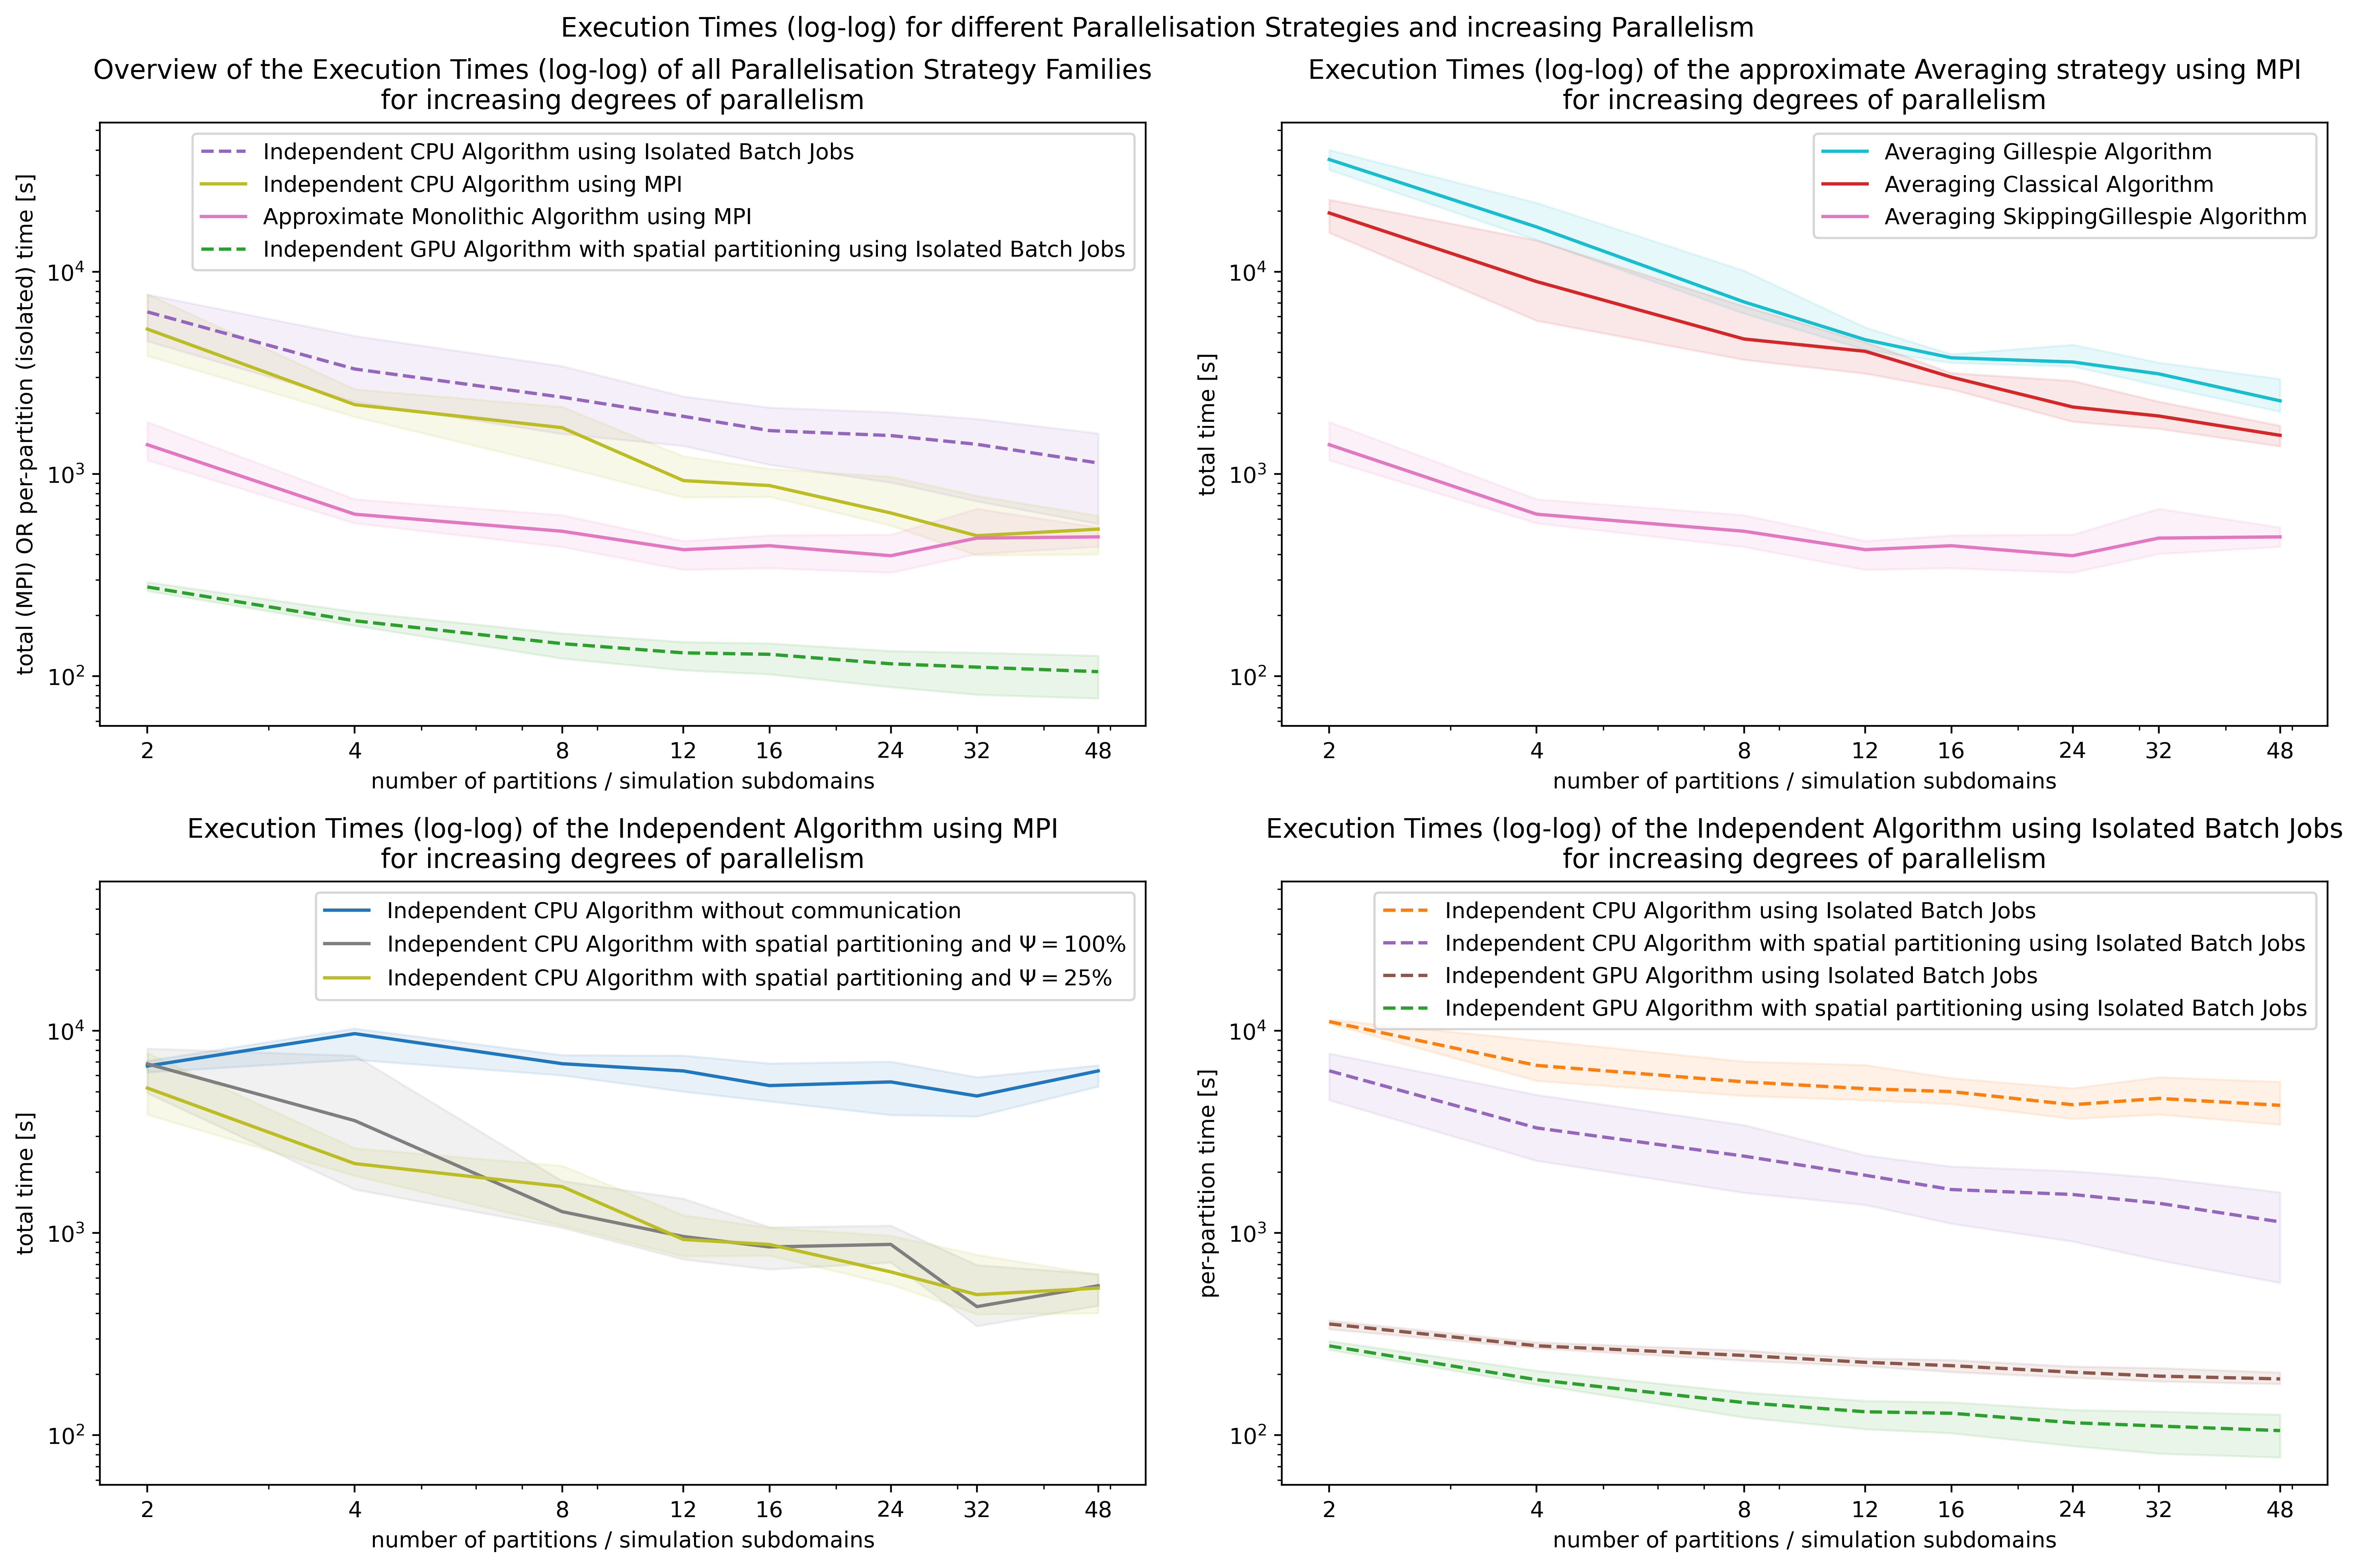

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title("Overview of the Execution Times (log-log) of all Parallelisation Strategy Families\nfor increasing degrees of parallelism")
ax1.set_xlabel("number of partitions / simulation subdomains")
ax1.set_ylabel("total (MPI) OR per-partition (isolated) time [s]")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylim(ylim)

for algorithm, colour, label in [("IndependentIsolatedLandscape", "#9467bd", "Independent CPU Algorithm using Isolated Batch Jobs")]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = ISOLATED_PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))
        
        results[partitions].append((initialisation, execution, cleanup))

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    ax1.plot(partitionss, np.array(executions)[:,0], color=colour, linestyle='--', label=label)
    ax1.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=colour, alpha=0.1
    )

for algorithm, colour, label in [
    ("IndependentProbabilistic", "#bcbd22", "Independent CPU Algorithm using MPI"),
    ("SkippingGillespieAveraging", "#e377c2", "Approximate Monolithic Algorithm using MPI")
]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = BIODIVERSITY_PATTERN.search(stdout)
        if match is None:
            continue
        biodiversity = int(match.group(1))

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))

        results[partitions].append((biodiversity, initialisation, execution, cleanup))
        
    if len(results) == 0:
        continue

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, biodiversities, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    ax1.plot(partitionss, np.array(executions)[:,0], color=colour, label=label)
    ax1.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=colour, alpha=0.1
    )
    
for algorithm, colour, label in [("CudaIsolatedLandscape", "#2ca02c", "Independent GPU Algorithm with spatial partitioning using Isolated Batch Jobs")]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = ISOLATED_PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))
        
        results[partitions].append((initialisation, execution, cleanup))

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    ax1.plot(partitionss, np.array(executions)[:,0], color=colour, linestyle='--', label=label)
    ax1.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=colour, alpha=0.1
    )

ax1.set_xticks(partitionss)
ax1.set_xticklabels(str(p) for p in partitionss)
ax1.legend()




ax2.set_title("Execution Times (log-log) of the approximate Averaging strategy using MPI\nfor increasing degrees of parallelism")
ax2.set_xlabel("number of partitions / simulation subdomains")
ax2.set_ylabel("total time [s]")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylim(ylim)

for algorithm, colour, label in [
    ("GillespieAveraging", "#17becf", "Averaging Gillespie Algorithm"),
    ("ClassicalAveraging", "#d62728", "Averaging Classical Algorithm"),
    ("SkippingGillespieAveraging", "#e377c2", "Averaging SkippingGillespie Algorithm")
]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = BIODIVERSITY_PATTERN.search(stdout)
        if match is None:
            continue
        biodiversity = int(match.group(1))

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))

        results[partitions].append((biodiversity, initialisation, execution, cleanup))
        
    if len(results) == 0:
        continue

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, biodiversities, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    ax2.plot(partitionss, np.array(executions)[:,0], color=colour, label=label)
    ax2.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=colour, alpha=0.1
    )

ax2.set_xticks(partitionss)
ax2.set_xticklabels(str(p) for p in partitionss)
ax2.legend()




ax3.set_title("Execution Times (log-log) of the Independent Algorithm using MPI\nfor increasing degrees of parallelism")
ax3.set_xlabel("number of partitions / simulation subdomains")
ax3.set_ylabel("total time [s]")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylim(ylim)

for algorithm, colour, label in [
    ("IndependentIndividuals", "#1f77bf", "Independent CPU Algorithm without communication"),
    ("IndependentLandscape", "#7f7f7f", "Independent CPU Algorithm with spatial partitioning and $\Psi = 100\%$"),
    ("IndependentProbabilistic", "#bcbd22", "Independent CPU Algorithm with spatial partitioning and $\Psi = 25\%$")
]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = BIODIVERSITY_PATTERN.search(stdout)
        if match is None:
            continue
        biodiversity = int(match.group(1))

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))

        results[partitions].append((biodiversity, initialisation, execution, cleanup))
        
    if len(results) == 0:
        continue

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, biodiversities, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    ax3.plot(partitionss, np.array(executions)[:,0], color=colour, label=label)
    ax3.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=colour, alpha=0.1
    )

ax3.set_xticks(partitionss)
ax3.set_xticklabels(str(p) for p in partitionss)
ax3.legend()




ax4.set_title("Execution Times (log-log) of the Independent Algorithm using Isolated Batch Jobs\nfor increasing degrees of parallelism")
ax4.set_xlabel("number of partitions / simulation subdomains")
ax4.set_ylabel("per-partition time [s]")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylim(ylim)

for algorithm, colour, label in [
    ("IndependentIsolatedIndividuals", "#ff7f0e", "Independent CPU Algorithm using Isolated Batch Jobs"),
    ("IndependentIsolatedLandscape", "#9467bd", "Independent CPU Algorithm with spatial partitioning using Isolated Batch Jobs"),
    ("CudaIsolatedIndividuals", "#8c564b", "Independent GPU Algorithm using Isolated Batch Jobs"),
    ("CudaIsolatedLandscape", "#2ca02c", "Independent GPU Algorithm with spatial partitioning using Isolated Batch Jobs")
]:
    results = defaultdict(list)
    
    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = ISOLATED_PARTITIONS_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        partitions = int(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))
        
        results[partitions].append((initialisation, execution, cleanup))

    results = { partitions: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for partitions, result in results.items() }
    
    partitionss, initialisations, executions, cleanups = zip(*sorted([partitions] + rs for partitions, rs in results.items()))
    
    ax4.plot(partitionss, np.array(executions)[:,0], color=colour, linestyle='--', label=label)
    ax4.fill_between(
        partitionss,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=colour, alpha=0.1
    )

ax4.set_xticks(partitionss)
ax4.set_xticklabels(str(p) for p in partitionss)
ax4.legend()




fig.suptitle("Execution Times (log-log) for different Parallelisation Strategies and increasing Parallelism")

plt.tight_layout()
plt.show()